
We will make use of Naive Bayes algorithm to perform sentiment analysis on the movie review dataset.

## Importing the Libraries

In [1]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

## Reading the data

When reading the data, ensure that the '.csv' file is in the same location where your jupyter notebook is used. This way the files are organized and easy to read using the pandas library. 

In [2]:
## Reading the data and removing columns that are not important. 
df = pd.read_csv("movie_reviews.csv", sep = ',', encoding = 'latin-1', usecols = lambda col: col not in ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"])

In [3]:
df.head()  # print head of data frame with help of head function

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,"Petter Mattei's ""Love in the Time of Money"" is...",positive
4,"Probably my all-time favorite movie, a story o...",positive


## Count plot of the output categories: positive or negative

Feel free to take a look at the output and whether the classes are balanced or imbalanced. 

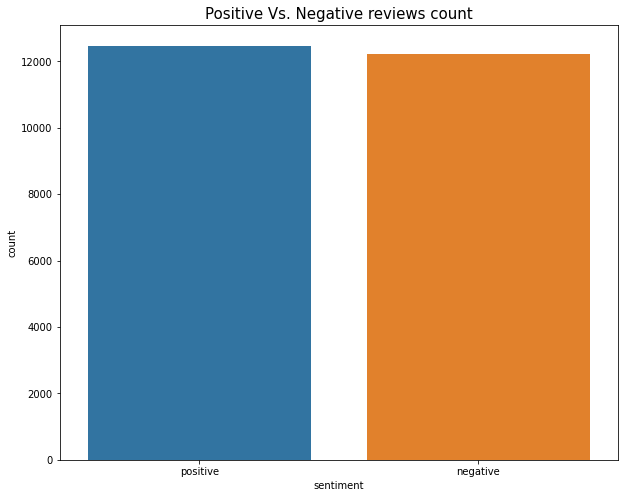

In [4]:
plt.figure(figsize = (10, 8))
sns.countplot(df['sentiment'])
plt.title("Positive Vs. Negative reviews count", fontsize = 15)
plt.show()

In [5]:
## hint: use resample from sklearn.utils
from sklearn.utils import resample

df_majority = df[df['sentiment']=='positive']
df_minority = df[df['sentiment']=='negative']
negative_upsample = resample(df_minority, replace = True, 
                        n_samples = df_majority.shape[0],
                        random_state = 101)

df_upsampled = pd.concat([df_majority, negative_upsample])  # concat two data frames i,e majority class data set and upsampled minority class data set
df_upsampled = df_upsampled.sample(frac = 1)

In [6]:
## Just to ensure that upsampling was done successfully, take a look at the shape of the data in 
## this cell. 

# print the shape of data set with the help of shape function having "negative" as class label
df_upsampled[df_upsampled['sentiment'] == 'negative'].shape

(12474, 2)

### Expected Output : 
(12474, 2)

In [7]:
## Ensure that the same number of data points are present for both 'positive' and 'negative' data

# print the shape of data set with the help of shape function having "positive" as class label
df_upsampled[df_upsampled['sentiment'] == 'positive'].shape

(12474, 2)

### Expected Output : 
(12474, 2)

In [8]:
## In this cell, we are going to be dividing the data into train and test points
## Ensure that you store the upsampled data in a variable called 'df_upsampled' 
## so that the below operations are performed successfully


## Considering 10000 positive and 10000 negative data points
negative_data_points_train = df_upsampled[df_upsampled['sentiment'] == 'negative'].iloc[:10000]
positive_data_points_train = df_upsampled[df_upsampled['sentiment'] == 'positive'].iloc[:10000]

## Considering the remaining data points for test
negative_data_points_test = df_upsampled[df_upsampled['sentiment'] == 'negative'].iloc[10000:]
positive_data_points_test = df_upsampled[df_upsampled['sentiment'] == 'positive'].iloc[10000:]

## Concatenate the training positive and negative reviews
X_train = pd.concat([positive_data_points_train['review'], negative_data_points_train['review']])
## Concatenating the training positive and negative outputs
y_train = pd.concat([positive_data_points_train['sentiment'], negative_data_points_train['sentiment']])

## Concatenating the test positive and negative reviews
X_test = pd.concat([positive_data_points_test['review'], negative_data_points_test['review']])
## Concatenating the test positive and negative outputs
y_test = pd.concat([positive_data_points_test['sentiment'], negative_data_points_test['sentiment']])


In [9]:
## Take a look at the total number of classes and their count using '.value_counts()' for y_train and y_test.
## Ensure that there are equal number of positive and negative reviews. 
y_train.value_counts()

negative    10000
positive    10000
Name: sentiment, dtype: int64

### Expected Output:
negative    10000<br>
positive    10000<br>
Name: sentiment, dtype: int64

In [10]:
y_test.value_counts()

negative    2474
positive    2474
Name: sentiment, dtype: int64

### Expected Output : 
negative    2474<br>
positive    2474<br>
Name: sentiment, dtype: int64

## Q1. Pre-process the reviews: (10 points)

We know that a review contains links, punctuation, stopwords and many other words that don't give a lot of meaning for the Naive Bayes model for prediction. 

In the cell below, one must implement text-preprocessing and remove links, punctuations and stopwords. It is also important to lowercase the letters so that 'Admire' and 'admire' are not treated as different words. 

In addition to this, perform stemming operation so that similar words are reduced. To know more about stemming, feel free to take a look at this link.

https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html

In [11]:
# TASK CELL
def clean_review(review):
    ps = PorterStemmer()
    stop_words = stopwords.words('english')+['']
    review = re.sub(r'[^\w\s]','', review)
    review = re.sub(r'http\S+','', review)
    review_cleaned = [word.lower() for word in review.split(' ') if word.lower() not in stop_words]
    # Stemming words
    review_cleaned = [ps.stem(word) for word in review_cleaned]
    # Joining list to string    
    review_cleaned = ' '.join(review_cleaned)
    # Returning String     
    return review_cleaned

## Q2. Implement a find_occurrence function (5 points):

In this function, we find the total occurrence of a word giving information such as label, word and frequency dictionary.

Note that this function is used later in the code when we are going to be predicting the output using Naive Bayes. 

In [12]:
# TASK CELL
def find_occurrence(frequency, word, label):
    '''
    Params:
        frequency: a dictionary with the frequency of each pair (or tuple)
        word: the word to look up
        label: the label corresponding to the word
    Return:
        n: the number of times the word with its corresponding label appears.
    '''
    n = 0  # freqs.get((word, label), 0)

    dic = (word, label)
    if(dic in frequency):
        n = freqs[dic]
    return n

### Converting output to numerical format:

We have outputs as 'positive' or 'negative'. In the cell below, we convert it to a numerical format. 

In [13]:
## With the use of mapping function, we replace
## the label in the form of string to an integer. 

output_map = {'positive': 0, 'negative': 1}
y_train = y_train.map(output_map)
y_test = y_test.map(output_map)

In [14]:
## Ensuring that there are equal number of classes on the training data. 
y_train.value_counts()

1    10000
0    10000
Name: sentiment, dtype: int64

In [15]:
## Choosing a random review and taking a look at it.
X_train.iloc[0]

'Like another poster mentioned Ch. 56 (a local Boston TV station) showed this multiple times over the years on Saturday afternoons. They paired it with the first sequel "Return of the Ginat Majin".<br /><br />Now I haven\'t seen it since then...but it never left me. Aside from the atrocious dubbing and faded color this was a pretty good fantasy. Technically it isn\'t horror...until the statue comes to life at the end. It\'s just about a village ruled over by an evil man. There\'s a giant stone statue there that the villagers keep praying to to help them...to no avail. But things go too far, the statute comes to life and destroys the bad guys...but then it starts going after the good guys too! Well-done with some cool special effects at the end (LOVED how he got rid of the main bad guy). Also there was an enchanted forest worked in which was kind of interesting too.<br /><br />No masterpiece but an unusual combo fantasy/horror film. Worth catching--but not if it\'s the dubbed print.'

From the above cell output, it could be seen that there are a lot of words that don't add a lot of meaning to the text. 

Therefore, those words would be removed. It also reduces the computation time. 

Therefore, it is a good practice we are following.

In [16]:
custom_review = X_train.iloc[0]

# print cleaned review
print(clean_review(custom_review))

like anoth poster mention ch 56 local boston tv station show multipl time year saturday afternoon pair first sequel return ginat majinbr br havent seen sinc thenbut never left asid atroci dub fade color pretti good fantasi technic isnt horroruntil statu come life end villag rule evil man there giant stone statu villag keep pray help themto avail thing go far statut come life destroy bad guysbut start go good guy welldon cool special effect end love got rid main bad guy also enchant forest work kind interest toobr br masterpiec unusu combo fantasyhorror film worth catchingbut dub print


We now use this function to pre-process the review and remove words that don't add a lot of meaning in our model. 

## Q3. Implementing review counter function: (5 points)

It is now time to implement the count function for the reviews. 

In this function, we count the occurrence of words and get the probabilities 
for the words based on the training data. 

In other words, we get the probability of occurrence of a word, given that the output is 'positive'.

Similarly, we also compute the probability of occurence of a word, given that the output is 'negative'.



In [17]:
# TASK CELL
def review_counter(output_occurrence, reviews, positive_or_negative):
    '''
    Params:
        output_occurrence: a dictionary that will be used to map each pair to its frequency
        reviews: a list of reviews
        positive_or_negative: a list corresponding to the sentiment of each review (either 0 or 1)
    Return:
        output: a dictionary mapping each pair to its frequency
    '''
    for label, review in zip(positive_or_negative, reviews):
        split_review = clean_review(review).split(' ')
        for word in split_review:
            # Your code here
            if((word, label) in output_occurrence):
                output_occurrence[(word, label)] += 1
            else:
                output_occurrence[(word, label)] = 1
    return output_occurrence

### Test your function with example reviews:

Feel free to run the cell below and understand whether the above function that you have defined is producing the optimum results. 

In [18]:
# Testing your function

result = {}
reviews = ['got bored throught the moview', 'The movie was fantastic', 'Will not watch it again', 'Was bored, it was a complete waste of time and money', 'Enjoyed the movie to the fullest']
ys = [1, 0, 1, 1, 0]
review_counter(result,reviews, ys)

{('got', 1): 1,
 ('bore', 1): 2,
 ('throught', 1): 1,
 ('moview', 1): 1,
 ('movi', 0): 2,
 ('fantast', 0): 1,
 ('watch', 1): 1,
 ('complet', 1): 1,
 ('wast', 1): 1,
 ('time', 1): 1,
 ('money', 1): 1,
 ('enjoy', 0): 1,
 ('fullest', 0): 1}

### Expected Output:
 {('bored', 1): 2, <br>
 ('complete', 1): 1, <br>
 ('enjoyed', 0): 1, <br>
 ('fantastic', 0): 1, <br>
 ('fullest', 0): 1, <br>
 ('got', 1): 1, <br>
 ('money', 1): 1, <br>
 ('movie', 0): 2, <br>
 ('moview', 1): 1, <br>
 ('throught', 1): 1, <br>
 ('time', 1): 1, <br>
 ('waste', 1): 1, <br>
 ('watch', 1): 1}

In [19]:
# Build the freqs dictionary for later uses
freqs = review_counter({}, X_train, y_train)

In [20]:
## Run this cell to get an idea about the corpus of words and their occurrence along with labels. 
## In this, we are computing the frequency of occurrence of word given that a review is 'positive'.
## Similarly, we also compute the frequence of occurence of word given that a review is 'negative'.
freqs

{('like', 0): 7970,
 ('anoth', 0): 1630,
 ('poster', 0): 83,
 ('mention', 0): 518,
 ('ch', 0): 2,
 ('56', 0): 17,
 ('local', 0): 412,
 ('boston', 0): 26,
 ('tv', 0): 1102,
 ('station', 0): 161,
 ('show', 0): 4371,
 ('multipl', 0): 87,
 ('time', 0): 6106,
 ('year', 0): 2883,
 ('saturday', 0): 84,
 ('afternoon', 0): 70,
 ('pair', 0): 162,
 ('first', 0): 3508,
 ('sequel', 0): 277,
 ('return', 0): 548,
 ('ginat', 0): 1,
 ('majinbr', 0): 1,
 ('br', 0): 22252,
 ('havent', 0): 362,
 ('seen', 0): 2625,
 ('sinc', 0): 1174,
 ('thenbut', 0): 3,
 ('never', 0): 2493,
 ('left', 0): 715,
 ('asid', 0): 189,
 ('atroci', 0): 19,
 ('dub', 0): 124,
 ('fade', 0): 70,
 ('color', 0): 375,
 ('pretti', 0): 1162,
 ('good', 0): 5855,
 ('fantasi', 0): 272,
 ('technic', 0): 178,
 ('isnt', 0): 1008,
 ('horroruntil', 0): 1,
 ('statu', 0): 120,
 ('come', 0): 2654,
 ('life', 0): 2963,
 ('end', 0): 3501,
 ('villag', 0): 163,
 ('rule', 0): 187,
 ('evil', 0): 483,
 ('man', 0): 2438,
 ('there', 0): 910,
 ('giant', 0): 138

## Q4. Training the Naive Bayes Model: (20 points)

Now we are in the training phase of the Naive Bayes algorithm. In this cell, take a look at the ways to calculate the log likelihood and log prior values as these are important for testing in the next few cells. 

Also calculate the frequency of occurrence of words where the output is negative. In the same way, calculate the word frequency count using the above functions in order to compute the log likelihood.

Return the logprior and loglikelihood output by the model from this function. 

In [21]:
def train_naive_bayes(freqs, train_x, train_y):
    '''
    Input:
        freqs: dictionary from (word, label) to how often the word appears
        train_x: a list of reviews
        train_y: a list of labels correponding to the reviews (0,1)
    Output:
        logprior: the log prior. (equation 3 above)
        loglikelihood: the log likelihood of you Naive bayes equation. (equation 6 above)
    '''
    loglikelihood = {}
    logprior = 0
    # calculate V, the number of unique words in the vocabulary
    vocab = set([pair[0] for pair in freqs.keys()])
    V = len(vocab)

    # calculate num_pos and num_neg - the total number of positive and negative words for all documents
    num_pos = num_neg = 0
    for pair in freqs.keys():
        # if the label is positive (greater than zero)
        if pair[1] > 0:
            num_pos += freqs[pair]
        else:
            num_neg += freqs[pair]

    # Calculate num_doc, the number of documents
    num_doc = train_y.shape[0]

    # Calculate D_pos, the number of positive documents 
    pos_num_docs = train_y[train_y == 0].shape[0]

    # Calculate D_neg, the number of negative documents 
    neg_num_docs = train_y[train_y == 1].shape[0]

    # Calculate logprior
    logprior = np.log(pos_num_docs) - np.log(neg_num_docs)

    # For each word in the vocabulary...
    for word in vocab:
        # get the positive and negative frequency of the word
        freq_pos = find_occurrence(freqs, word, 1) # freqs.get((word, 1), 0)
        freq_neg = find_occurrence(freqs, word, 0)

        # calculate the probability that each word is positive, and negative
        p_w_pos = (freq_pos + 1) / (num_pos + V)
        p_w_neg = (freq_neg + 1) / (num_neg + V)

        # calculate the log likelihood of the word
        loglikelihood[word] = np.log(p_w_pos/p_w_neg)

    return logprior, loglikelihood

In [22]:
# You do not have to input any code in this cell, but it is relevant to grading, so please do not change anything
logprior, loglikelihood = train_naive_bayes(freqs, X_train, y_train)
print(logprior)
print(len(loglikelihood))

0.0
75444


### Expected Output 

0.0 <br>
91425

## Q5. Implementing Naive Bayes Predict Function: (10 points)

It is now time to make our prediction as to whether a given review is negative or positive respectively. 

After adding the log likelihood values, ensure that the output is 1 (negative) if the sum of the log likelihood value is greater than 0 and 0 (positive) if the sum of the log likelihood is less than or equal to 0. 

In [23]:
# TASK 4 CELL

def naive_bayes_predict(review, logprior, loglikelihood):
    '''
    Params:
        review: a string
        logprior: a number
        loglikelihood: a dictionary of words mapping to numbers
    Return:
        total_prob: the sum of all the loglikelihoods of each word in the review (if found in the dictionary) + logprior (a number)
    '''
    # process the review to get a list of words
    word_l = clean_review(review).split()
#     print("WORD_L:   ", word_l)
    # initialize probability to zero
    total_prob = 0

    # add the logprior
    total_prob += logprior

    for word in word_l:
        # check if the word exists in the loglikelihood dictionary
        if word in loglikelihood:
            total_prob = total_prob + loglikelihood[word]
#             print(total_prob, loglikelihood[word])
    if total_prob > 0:
        total_prob = 1
    else:
        total_prob = 0

    return total_prob

In [24]:
# You do not have to input any code in this cell, but it is relevant to grading, so please do not change anything

# Experiment with your own review.
my_review = "I thought this series was going to be another fun, action series with some dynamic plots and great performances. I was wrong. While I like Jamie Denton, this show is hardly worth watching at all, unless you enjoy watching some people brutalized and the actions of the agents supposedly warranted under the theme of national security. The show is great propaganda for the current government, and spews out jingoism as though we talk that way every day. After a couple of episodes, it was boring the hell out of me, and I started watching reruns of House Invaders on BBCAmerica instead. Rather watch CSI and Without a Trace, without a doubt."
p = naive_bayes_predict(my_review, logprior, loglikelihood)
print('The expected output is', p)

The expected output is 1


### Expected Output :
The expected output is 1

## Q6. Implementing Naive Bayes Test function: (10 points)

In this function, implement the previous functions such as naive_bayes_predict to get the predictions for the test set. 

In addition to this, the function should return the total number of reviews that it correctly classified as 'positive' or 'negative'. 

In [25]:
# UNQ_C6 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def test_naive_bayes(test_x, test_y, logprior, loglikelihood):
    """
    Input:
        test_x: A list of reviews
        test_y: the corresponding labels for the list of reviews
        logprior: the logprior
        loglikelihood: a dictionary with the loglikelihoods for each word
    Output:
        accuracy: (# of reviews classified correctly)/(total # of reviews)
    """
    accuracy = 0  

    y_hats = []
    for review in test_x:
        if naive_bayes_predict(review, logprior, loglikelihood) >0:
            y_hat_i = 1
        else:
            y_hat_i = 0

        # append the predicted class to the list y_hats
        y_hats.append(y_hat_i)

    # error is the average of the absolute values of the differences between y_hats and test_y
    error = np.mean(y_hats!=test_y)

    accuracy = np.mean(y_hats==test_y)

    return accuracy

test_naive_bayes(X_test, y_test, logprior, loglikelihood)

0.8763136620856912

In [26]:
# For grading purpose only
# You do not have to input any code in this cell, but it is relevant to grading, so please do not change anything

# Run this cell to test your function

for review in ["If you like original gut wrenching laughter you will like this movie. If you are young or old then you will love this movie, hell even my mom liked it.<br /><br />Great Camp!!!",
                "What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative direction, too. Some VERY faint echoes of Fargo here, but it just doesn't come off.",
                "I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the romance between Joe and Jean keeps me on the edge of my seat, plus I still think Bryan Brown is the tops. Brilliant Film.",
                "Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement value. About as unentertaining, uninstructive and just plain dull as a film can be."]:
    p = naive_bayes_predict(review, logprior, loglikelihood)
    print(f'{review[:100]} -> {p:.2f}')
    

If you like original gut wrenching laughter you will like this movie. If you are young or old then y -> 0.00
What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative  -> 1.00
I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the -> 0.00
Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement val -> 1.00


### Expected Output :

If you like original gut wrenching laughter you will like this movie. If you are young or old then y -> 0.00 <br>
What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative  -> 1.00<br>
I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the -> 0.00 <br>
Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement val -> 1.00



In [27]:
# Feel free to check the sentiment of your own review below
my_review = 'The moview was very boring, I wanted to leave in the middle'
naive_bayes_predict(my_review, logprior, loglikelihood)

1

### Expected Output :
1

# Q7. Evaluate the accuracy (10 Points)
1. Split your data into training and test sets using random selection. Set the seed as parameter of the function so that user can select a different training and test set by changin seed.

2. Calculate model paramters with training set.

3. Print confusion matrix for training and test set.

4. Examine False Positive and False Negative cases and provide reasoning why they get misclassified.

In [28]:
X = df['review']
y = df['sentiment']

In [29]:
seed = 1234
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = seed)

output_map = {'positive': 0, 'negative': 1}
y_train = y_train.map(output_map)
y_test = y_test.map(output_map)

train_predictions = [naive_bayes_predict(review, logprior, loglikelihood) for review in X_train]

In [30]:
print("Training Set Confusion Matrix:")
training_metrics = confusion_matrix(y_train, train_predictions)
print(training_metrics)

Training Set Confusion Matrix:
[[8933 1059]
 [ 897 8870]]


In [31]:
test_predictions = [naive_bayes_predict(review, logprior, loglikelihood) for review in X_test]

In [32]:
print("Training Accuracy: ", np.mean(train_predictions==y_train)*100)
print("Testing Accuracy: ", np.mean(test_predictions==y_test)*100)

Training Accuracy:  90.10071359886635
Testing Accuracy:  90.54655870445345


In [33]:
print("Testing Set Confusion Matrix:")
testing_metrics = confusion_matrix(y_test, test_predictions)
print(testing_metrics)

Testing Set Confusion Matrix:
[[2240  242]
 [ 225 2233]]


In [34]:
print("Training False Positive: ", training_metrics[0][1])
print("Training False Negative: ", training_metrics[1][0])

Training False Positive:  1059
Training False Negative:  897


In [35]:
print("Testing False Positive: ", testing_metrics[0][1])
print("Testing False Negative: ", testing_metrics[1][0])

Testing False Positive:  242
Testing False Negative:  225


# Q8. Modularize your calssifier (10 points)
1. Convert your code into a python module text_classifier.py

2. The user should be able to launch the application on command prompt using python test_classifier.py command. The module will automatically load the model paramters from a local file of your choice and be ready to take the input from user on command prompt. The program will preprocess user input, tokenize and predict the class.

3. Your module will take the input from user and output sentiment class in an indefinite loop. The output should printout the probabilities for each input token along with the final classification decision. Program will quit if user enters X.


In [36]:
import pickle
pickle.dump([logprior,loglikelihood], open("output","wb"))

# Q9. Theory Questions: (10 points)

1. Why is Laplace Smoothing or Additive Smoothing required while executing Naive Bayes operations, especially for text classification? Show how not having additive smoothing leads to bad outcomes by using an example of training and the test set. (10 points)

When classifying unknown data, Laplace smoothing or additive smoothing is employed to avoid division by zero and over-confidence. The problem of having a zero probability arises in text classification when a certain term in the test set has not been observed in the training set. If we do not smooth the count of words, the chance of that class falls to zero, and the overall probability falls to zero, resulting in inaccurate predictions.

Consider the following binary classification issue with two classes: positive and negative. We offer a practice set that includes 10 good and 10 negative reviews. In good reviews, the term "bad" appears two times and five times in negative reviews.

Without smoothing, the likelihood of the word "bad" in a positive class is 2/10=0.2 and 5/10=0.5 in a negative class.

Consider a test review in which the words "poor" and "worse" appear. The word "worse" is not in the training set. Without smoothing, the probability of the positive class falls to zero since the probability of the term "worse" in the supplied positive class is zero, and therefore the product falls to zero. The same holds true for the negative class.

Laplace smoothing (also known as additive smoothing) involves adding a smoothing parameter, often 1, to each word count. Given a positive class, the probability of the word "bad" becomes (2+1)/(10+2)=0.25, while given a negative class, it becomes (5+1)/(10+2)=0.5. Given a positive class, the probability of the term "worse" becomes (0+1)/(10+2)=0.05, while given a negative class, it becomes (0+1)/(10+2)=0.05.

In [39]:
def train_naive_bayes(freqs, train_x, train_y):
    '''
    Input:
        freqs: dictionary from (word, label) to how often the word appears
        train_x: a list of reviews
        train_y: a list of labels correponding to the reviews (0,1)
    Output:
        logprior: the log prior. (equation 3 above)
        loglikelihood: the log likelihood of you Naive bayes equation. (equation 6 above)
    '''
    loglikelihood = {}
    logprior = 0
    # calculate V, the number of unique words in the vocabulary
    vocab = set([pair[0] for pair in freqs.keys()])
    V = len(vocab)

    # calculate num_pos and num_neg - the total number of positive and negative words for all documents
    num_pos = num_neg = 0
    for pair in freqs.keys():
        # if the label is positive (greater than zero)
        if pair[1] > 0:
            num_pos += freqs[pair]
        else:
            num_neg += freqs[pair]

    # Calculate num_doc, the number of documents
    num_doc = train_y.shape[0]

    # Calculate D_pos, the number of positive documents 
    pos_num_docs = train_y[train_y == 0].shape[0]

    # Calculate D_neg, the number of negative documents 
    neg_num_docs = train_y[train_y == 1].shape[0]

    # Calculate logprior
    logprior = np.log(pos_num_docs) - np.log(neg_num_docs)

    # For each word in the vocabulary...
    for word in vocab:
        # get the positive and negative frequency of the word
        freq_pos = find_occurrence(freqs, word, 1) # freqs.get((word, 1), 0)
        freq_neg = find_occurrence(freqs, word, 0)

        # calculate the probability that each word is positive, and negative
        p_w_pos = (freq_pos) / (num_pos)
        p_w_neg = (freq_neg) / (num_neg)

        # calculate the log likelihood of the word
        loglikelihood[word] = np.log(p_w_pos/p_w_neg)

    return logprior, loglikelihood

In [40]:
# You do not have to input any code in this cell, but it is relevant to grading, so please do not change anything
logprior, loglikelihood = train_naive_bayes(freqs, X_train, y_train)
print(logprior)
print(len(loglikelihood))

ZeroDivisionError: float division by zero

As explained in the above, a particular word that is present in postive reviews is not present in the negative reviews, thus our p_w_neg = 0 which is then divided in the demominator to calculate loglikelihood.

In [41]:
# TASK 4 CELL

def naive_bayes_predict(review, logprior, loglikelihood):
    '''
    Params:
        review: a string
        logprior: a number
        loglikelihood: a dictionary of words mapping to numbers
    Return:
        total_prob: the sum of all the loglikelihoods of each word in the review (if found in the dictionary) + logprior (a number)
    '''
    # process the review to get a list of words
    word_l = clean_review(review).split()
#     print("WORD_L:   ", word_l)
    # initialize probability to zero
    total_prob = 0

    # add the logprior
    total_prob += logprior

    for word in word_l:
        # check if the word exists in the loglikelihood dictionary
        if word in loglikelihood:
            total_prob = total_prob + loglikelihood[word]
#             print(total_prob, loglikelihood[word])
    if total_prob > 0:
        total_prob = 1
    else:
        total_prob = 0

    return total_prob

2. Why are logarithmic values computed instead of only probability values in the Naive Bayes algorithm? (5 points)

In the Naive Bayes algorithm, we figure out how likely a class is based on a set of characteristics. These probabilities can become extremely small, particularly for large datasets, resulting in underflow issues when storing or manipulating the numbers in a computer. To avoid this, it is typical to operate using the probabilities' logarithms instead. A small number's logarithm is a large negative number, but the logarithm of a product is the sum of the logarithms, therefore multiplying several small numbers yields a manageable total of negative numbers. So, instead of multiplying the probabilities, we compute the logarithms of the probabilities and then sum the logarithmic values in the Naive Bayes process. This enables us to operate with smaller quantities and prevent underflow issues.